# CSCI 7000- Applied Deep Learning
## Hw-1 Salil Rabade

## Introduction
The dataset used here is available online at Kaggle (the fashion dataset).The work here is similar to the digit recognition dataset. It involves categorizing images in ten different categories. The original data is flattened. We convert it into the original 28X28 images.
The dataset can be found [here](https://www.kaggle.com/zalando-research/fashionmnist).The homework is organized as follows: Initially the data is evaluated using a dense neural network. This is followed by a Convolutional neural network and a deeper CNN. Finally batch sizes are varied to see effect of the hyperparameter

## Load all Libraries

In [17]:
# Import all libraries
from keras.models import Sequential,load_model
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers.core import Activation, Flatten ,Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from scipy import signal
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras import backend as K
import timeit

## Load Data

In [2]:
# Data Import and shape
# The raw data is 'flattened'.
train= pd.read_csv('fashion-mnist_train.csv').values # .values will convert csv to raw values for python
test=pd.read_csv('fashion-mnist_test.csv').values
print(train)
print(train.shape)

[[2 0 0 ... 0 0 0]
 [9 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 ...
 [8 0 0 ... 0 0 0]
 [8 0 0 ... 0 0 0]
 [7 0 0 ... 0 0 0]]
(60000, 785)


## Reshape Data

In [11]:
# Reshape data
# The data is reshaped into the 28X28 size image it originally represents.
trainX = train[:,1:]# semicolon after 1 shows data from 1 to last
trainX=trainX.reshape(train.shape[0],1,28,28).astype('float32')
print('The shape of training data for CNN is',trainX.shape)
testX = test[:,1:]# semicolon after 1 shows data from 1 to last
testX=testX.reshape(test.shape[0],1,28,28).astype('float32')
print('The shape of test data for CNN is',testX.shape)

testX_DN=test[:,1:]/255.0
trainX_DN=train[:,1:]/255.0
print('The shape of test data for DNN is',testX_DN.shape)
print('The shape of test data for DNN is',trainX_DN.shape)

#Normalize data
X_train = trainX / 255.0
X_test = testX/255.0
y_train = train[:,0]
y_test=test[:,0]
#print(trainX[5,0,:,:]) # Visualize the data in raw form for one image

## Convert output to 
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

The shape of training data for CNN is (60000, 1, 28, 28)
The shape of test data for CNN is (10000, 1, 28, 28)
The shape of test data for DNN is (10000, 784)
The shape of test data for DNN is (60000, 784)


## Visualize Data

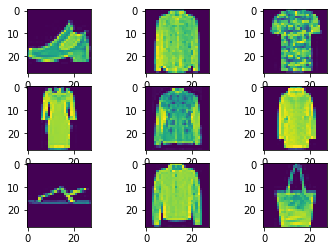

In [4]:
## Visualize Raw Data
for I in range (9) :
    plt.subplot (3,3,I+1)
    plt.imshow(X_train[I+1,0,:,:])
plt.show()
    

## Simple Dense Neural Network
The structure of the DNN is as follows:
Input-->FCN(128)-->FCN(64)-->softmax(10).The number of neurons are chosen to match the size of the batchsize.This model can predict with an accuracy of 91.43%. This particular architecture is chosen to match the FCN architecture of the CNN's to be explored later in this Homework.

In [28]:
model_DN = Sequential()
    #K.set_image_dim_ordering('th')
model_DN.add(Dense(128, input_shape=(784,)))
model_DN.add(Dense(64, activation= 'relu' ))
model_DN.add(Dense(10, activation= 'softmax' ))
# Compile model
model_DN.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])


##### Prediction and Evaluation #####
hist_DN=model_DN.fit(trainX_DN, y_train,
          epochs=20,
          batch_size=128 ,verbose=1, validation_split=0.2)
score_DN = model_DN.evaluate(testX_DN, y_test, batch_size=128)
model_DN.summary()

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 5s 103us/step - loss: 0.5851 - acc: 0.7979 - val_loss: 0.4781 - val_acc: 0.8342
Epoch 2/20
48000/48000 [==============================] - 3s 59us/step - loss: 0.4268 - acc: 0.8500 - val_loss: 0.4413 - val_acc: 0.8460
Epoch 3/20
48000/48000 [==============================] - 3s 59us/step - loss: 0.3907 - acc: 0.8618 - val_loss: 0.4009 - val_acc: 0.8585
Epoch 4/20
48000/48000 [==============================] - 2s 47us/step - loss: 0.3613 - acc: 0.8700 - val_loss: 0.3935 - val_acc: 0.8614
Epoch 5/20
48000/48000 [==============================] - 2s 52us/step - loss: 0.3449 - acc: 0.8761 - val_loss: 0.3725 - val_acc: 0.8688
Epoch 6/20
48000/48000 [==============================] - 3s 66us/step - loss: 0.3278 - acc: 0.8824 - val_loss: 0.3802 - val_acc: 0.8667
Epoch 7/20
48000/48000 [==============================] - 3s 58us/step - loss: 0.3168 - acc: 0.8849 - val_loss: 0.3800 - val_ac

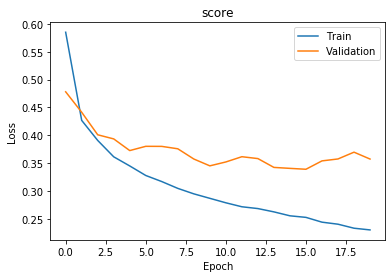

In [29]:
## PLot DNN Results
plt.plot(hist_DN.history['loss'])
plt.plot(hist_DN.history['val_loss'])
plt.title('score')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()

## Simple CNN
A simple Convolutional network is now constructed to evaluate the data. The structure is as follows :

Input-->Convolutional layers (30, 5X5)-->MaxPool(2X2)-->Convolutional layers (15, 3X3)-->MaxPool(2X2)-->FCN(64)-->softmax(10).A CNN can provide more accuracy while learning a significant lesser number of parameter. 

In [25]:
# Create CNN
# initialize the optimizer and model
start_time_CN1=timeit.default_timer()
model_CN1 = Sequential()
K.set_image_dim_ordering('th')
model_CN1.add(Conv2D(30, 5, 5, border_mode= 'valid' , input_shape=(1, 28, 28),activation= 'relu' ))
model_CN1.add(MaxPooling2D(pool_size=(2, 2)))
model_CN1.add(Conv2D(15, 3, 3, activation= 'relu' ))
model_CN1.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))
model_CN1.add(Flatten())
#model.add(Dense(128, activation= 'relu' ))
model_CN1.add(Dense(64, activation= 'relu' ))
model_CN1.add(Dense(10, activation= 'softmax' ))
# Compile model
model_CN1.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    

##### Prediction and Evaluation #####
hist_CN1=model_CN1.fit(X_train, y_train,
          epochs=20,
          batch_size= 128,verbose=1, validation_split=0.2)
score_CN1 = model_CN1.evaluate(X_test, y_test, batch_size=128) 
finish_time_CN1=timeit.default_timer()-start_time_CN1
model_CN1.summary()
print('The time to run is',finish_time_CN1,'seconds')

C:\Users\Salil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (5, 5), input_shape=(1, 28, 28..., activation="relu", padding="valid")`
  
C:\Users\Salil\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(15, (3, 3), activation="relu")`
  


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 29s 613us/step - loss: 0.6943 - acc: 0.7561 - val_loss: 0.4912 - val_acc: 0.8284
Epoch 2/20
48000/48000 [==============================] - 30s 624us/step - loss: 0.4485 - acc: 0.8385 - val_loss: 0.4184 - val_acc: 0.8515
Epoch 3/20
48000/48000 [==============================] - 31s 639us/step - loss: 0.3924 - acc: 0.8599 - val_loss: 0.3773 - val_acc: 0.8664
Epoch 4/20
48000/48000 [==============================] - 31s 646us/step - loss: 0.3622 - acc: 0.8718 - val_loss: 0.3632 - val_acc: 0.8718
Epoch 5/20
48000/48000 [==============================] - 31s 653us/step - loss: 0.3397 - acc: 0.8793 - val_loss: 0.3499 - val_acc: 0.8783
Epoch 6/20
48000/48000 [==============================] - 34s 701us/step - loss: 0.3181 - acc: 0.8863 - val_loss: 0.3335 - val_acc: 0.8843
Epoch 7/20
48000/48000 [==============================] - 34s 712us/step - loss: 0.3081 - acc: 0.8890 - val_loss: 0.

## CNN with additional dense layer

An additional deep layer increases accuracy from 92.55% to 93.84%. However the time to compute also increases from 687 secs to 824 secs.

In [26]:

# Create CNN
# initialize the optimizer and model
start_time_CN2=timeit.default_timer()
model_CN2 = Sequential()
K.set_image_dim_ordering('th')
model_CN2.add(Conv2D(30, 5, 5, border_mode= 'valid' , input_shape=(1, 28, 28),activation= 'relu' ))
model_CN2.add(MaxPooling2D(pool_size=(2, 2)))
model_CN2.add(Conv2D(15, 3, 3, activation= 'relu' ))
model_CN2.add(MaxPooling2D(pool_size=(2, 2)))
model_CN2.add(Flatten())
model_CN2.add(Dense(128, activation= 'relu' ))
model_CN2.add(Dense(64, activation= 'relu' ))
model_CN2.add(Dense(10, activation= 'softmax' ))
  # Compile model
model_CN2.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

C:\Users\Salil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (5, 5), input_shape=(1, 28, 28..., activation="relu", padding="valid")`
  
C:\Users\Salil\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(15, (3, 3), activation="relu")`
  


In [27]:
hist_CN2=model_CN2.fit(X_train, y_train,
          epochs=20,
          batch_size= 128,verbose=1, validation_split=0.2)
score_CN2 = model_CN2.evaluate(X_test, y_test, batch_size=128)
finish_time_CN2=timeit.default_timer()-start_time_CN2
model_CN2.summary()
print('The time to run is',finish_time_CN2,'seconds')

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 46s 967us/step - loss: 0.6516 - acc: 0.7637 - val_loss: 0.4739 - val_acc: 0.8277
Epoch 2/20
48000/48000 [==============================] - 47s 983us/step - loss: 0.4092 - acc: 0.8525 - val_loss: 0.3909 - val_acc: 0.8593
Epoch 3/20
48000/48000 [==============================] - 41s 860us/step - loss: 0.3594 - acc: 0.8700 - val_loss: 0.3554 - val_acc: 0.8726
Epoch 4/20
48000/48000 [==============================] - 38s 796us/step - loss: 0.3249 - acc: 0.8821 - val_loss: 0.3205 - val_acc: 0.8872
Epoch 5/20
48000/48000 [==============================] - 37s 761us/step - loss: 0.3028 - acc: 0.8915 - val_loss: 0.3214 - val_acc: 0.8853
Epoch 6/20
48000/48000 [==============================] - 36s 758us/step - loss: 0.2894 - acc: 0.8950 - val_loss: 0.3023 - val_acc: 0.8898
Epoch 7/20
48000/48000 [==============================] - 36s 747us/step - loss: 0.2723 - acc: 0.9008 - val_loss: 0.

In [60]:
print(score_CN2)

[0.26581965008974073, 0.9103]


## Hyperparameter Optimization
In neural networks, the number of layers, number of neurons in each layer, learning rate, optimizer, learning rate etc. are the hyperparamaters. From above neural networks, it is clear that adding an additional layer marginally increases accuracy , however with significant increase in computation time and parameters. Hence we evaluate the effect of batch size on the simpler CNN.

In [114]:
#from sklearn.model_selection import GridSearchCV
#batch_size=[128,256,512]
#epochs=[5,10,20]
#verbose=1
#validation_split=0.2

#params={'batch_size':batch_size,'epochs':epochs}
#modelhyp=GridSearchCV(model,params)
#modelhyp.fit=(X_train, y_train)

import time

batch_sizes=[64,512,2048,12000]
model_CN3 = Sequential()
K.set_image_dim_ordering('th')
model_CN3.add(Conv2D(30, 5, 5, border_mode= 'valid' , input_shape=(1, 28, 28),activation= 'relu' ))
model_CN3.add(MaxPooling2D(pool_size=(2, 2)))
model_CN3.add(Conv2D(15, 3, 3, activation= 'relu' ))
model_CN3.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))
model_CN3.add(Flatten())
#model.add(Dense(128, activation= 'relu' ))
model_CN3.add(Dense(64, activation= 'relu' ))
model_CN3.add(Dense(10, activation= 'softmax' ))
# Compile model
model_CN3.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])




C:\Users\Salil\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (5, 5), input_shape=(1, 28, 28..., activation="relu", padding="valid")`
C:\Users\Salil\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(15, (3, 3), activation="relu")`


In [115]:
score_CN3=np.zeros((len(batch_sizes),2))
elapsed_times_CN3=np.zeros((len(batch_sizes),2))
Hist_CN3_acc=[]
Hist_CN3_loss=[]
for I, batch_size in enumerate(batch_sizes):
    start_time_CN3=timeit.default_timer()
    result= model_CN3.fit(X_train, y_train,batch_size=batch_size, verbose=0, epochs=20, validation_split=0.2)
    Hist_CN3_acc.append(result.history['acc'])
    Hist_CN3_loss.append(result.history['loss'])
    score_CN3[I] = model_CN3.evaluate(X_test, y_test, verbose=0,batch_size=128)
    print(score_CN3[I])
    elapsed_times_CN3[I] =timeit.default_timer()- start_time_CN3
    
print(elapsed_times_CN3[I])
model_CN3.summary()

[0.26732148 0.9104    ]
[0.26957767 0.9178    ]
[0.2845025 0.9153   ]
[0.28755301 0.916     ]
[556.8124117 556.8124117]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 30, 24, 24)        780       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 12, 12)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 15, 10, 10)        4065      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 15, 5, 5)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 375)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 64)                24064     
______________________

Text(0, 0.5, 'time(sec)')

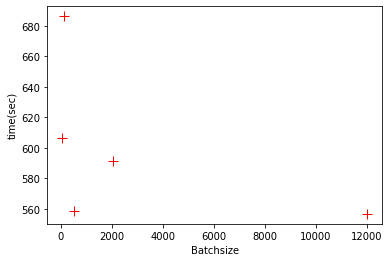

In [167]:

plt.plot(batch_sizes,elapsed_times_CN3[:,1],'r+',markersize=10)
plt.plot(128,finish_time_CN1,'r+',markersize=10)
plt.xlabel('Batchsize')
plt.ylabel('time(sec)')


Ideally, the runtime should decrease with increase in batch size. For this dataset, the CNN don't follow this trend fully. The CNN with 12000 as batch size takes the least time as expected but CNN with batch size 128 takes more time compared to 64 batchsize CNN. The validation accuracy is almost suprisingly similar in all cases

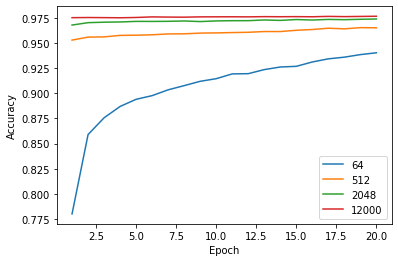

In [166]:
Acc=np.asarray(Hist_CN3_acc,dtype=np.float32)
ep=np.linspace(1, 20, num=20)

for J in range(4):
    plt.plot(ep,Acc[J,:])


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['64','512','2048','12000'])
plt.show()

## Conclusion
The accuracy is suprisingly observed to be highest in bigger batch size. This is contrary to expectation. 
The homework explores the design space of the hyperparameters. Specifically, the number of layers and the batchsize of the CNN is explored. It is clear that adding an extra layer has an impact on the accuracy but also increases the computation time. 

## References
1.https://www.freecodecamp.org/news/how-to-build-your-first-neural-network-to-predict-house-prices-with-keras-f8db83049159/
